# NBA Data Collection - Step by Step

**Goal:** Understand the NBA API and collect data for our prediction models.

**Strategy:**
1. Test API connection
2. Collect data for 1 season (small test)
3. Validate data quality
4. Scale up to all 5 seasons

**Important:** We'll test each step before moving forward!

In [1]:
# Imports
import pandas as pd
import numpy as np
import time
from pathlib import Path
import yaml

# NBA API
from nba_api.stats.endpoints import playergamelog, leaguegamelog
from nba_api.stats.static import players, teams

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Imports successful")

✓ Imports successful


## Step 1: Test NBA API Connection

Let's start simple - get a list of all NBA players and verify the API works.

In [2]:
# Get all NBA players (static data, no API call needed)
all_players = players.get_players()

print(f"Total players in NBA history: {len(all_players):,}")
print("\nExample player (LeBron James):")

# Find LeBron
lebron = [p for p in all_players if p['full_name'] == 'LeBron James'][0]
print(lebron)

Total players in NBA history: 5,019

Example player (LeBron James):
{'id': 2544, 'full_name': 'LeBron James', 'first_name': 'LeBron', 'last_name': 'James', 'is_active': True}


## Step 2: Get Game Logs for ONE Player (Test)

Before collecting data for 200 players, let's test with just LeBron for one season.

**Why test first?**
- Understand the data structure
- See what columns we get
- Verify API rate limiting works
- Catch issues early

In [3]:
# Get LeBron's game logs for 2023-24 season
print("Fetching LeBron's 2023-24 game logs...")
print("(This might take a few seconds)\n")

# Season format: "2023-24" for NBA API
lebron_id = lebron['id']
season = "2023-24"

# Make API call
gamelog = playergamelog.PlayerGameLog(
    player_id=lebron_id,
    season=season,
    season_type_all_star='Regular Season'  # Only regular season
)

# Convert to DataFrame
df_lebron = gamelog.get_data_frames()[0]

print(f"✓ Got {len(df_lebron)} games for LeBron in {season}")
print(f"✓ Columns: {df_lebron.shape[1]}")
print("\nFirst few games:")
df_lebron.head()

Fetching LeBron's 2023-24 game logs...
(This might take a few seconds)

✓ Got 71 games for LeBron in 2023-24
✓ Columns: 27

First few games:


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,2544,0022301195,"Apr 14, 2024",LAL @ NOP,W,38,11,20,0.550,0,2,0.000,6,6,1.000,2,9,11,17,5,1,4,0,28,19,1
1,22023,2544,0022301177,"Apr 12, 2024",LAL @ MEM,W,41,13,20,0.650,3,7,0.429,8,11,0.727,2,7,9,5,2,0,8,1,37,-3,1
2,22023,2544,0022301155,"Apr 09, 2024",LAL vs. GSW,L,36,14,22,0.636,1,3,0.333,4,5,0.800,1,6,7,11,2,0,4,0,33,-6,1
3,22023,2544,0022301127,"Apr 06, 2024",LAL vs. CLE,W,36,10,18,0.556,1,5,0.200,3,5,0.600,0,5,5,12,1,1,5,1,24,10,1
4,22023,2544,0022301103,"Apr 03, 2024",LAL @ WAS,W,36,9,18,0.500,0,1,0.000,7,9,0.778,2,5,7,9,3,0,4,2,25,9,1


## Step 3: Explore the Data Structure

Let's understand what data we have available.

In [4]:
# Show all columns
print("All available columns:")
print("=" * 50)
for i, col in enumerate(df_lebron.columns, 1):
    print(f"{i:2}. {col}")

All available columns:
 1. SEASON_ID
 2. Player_ID
 3. Game_ID
 4. GAME_DATE
 5. MATCHUP
 6. WL
 7. MIN
 8. FGM
 9. FGA
10. FG_PCT
11. FG3M
12. FG3A
13. FG3_PCT
14. FTM
15. FTA
16. FT_PCT
17. OREB
18. DREB
19. REB
20. AST
21. STL
22. BLK
23. TOV
24. PF
25. PTS
26. PLUS_MINUS
27. VIDEO_AVAILABLE


In [5]:
# Check key stats we care about
print("Key stats summary for LeBron (2023-24):")
print("=" * 50)

key_stats = ['PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG_PCT', 'FG3A', 'FG3_PCT', 'FTA', 'FT_PCT']

print(df_lebron[key_stats].describe())

Key stats summary for LeBron (2023-24):
             PTS        REB        AST        MIN        FGA     FG_PCT  \
count  71.000000  71.000000  71.000000  71.000000  71.000000  71.000000   
mean   25.661972   7.295775   8.295775  35.323944  17.873239   0.542239   
std     6.656777   3.283702   2.820306   4.683633   3.942188   0.106475   
min    10.000000   0.000000   2.000000  23.000000  10.000000   0.273000   
25%    21.000000   5.000000   6.000000  34.500000  15.000000   0.474000   
50%    25.000000   7.000000   8.000000  36.000000  18.000000   0.545000   
75%    30.000000   9.000000   9.500000  38.000000  20.000000   0.600000   
max    40.000000  20.000000  17.000000  48.000000  27.000000   0.833000   

            FG3A    FG3_PCT        FTA     FT_PCT  
count  71.000000  71.000000  71.000000  71.000000  
mean    5.112676   0.404592   5.690141   0.730859  
std     2.314854   0.254745   2.861526   0.264000  
min     1.000000   0.000000   0.000000   0.000000  
25%     4.000000   0.291

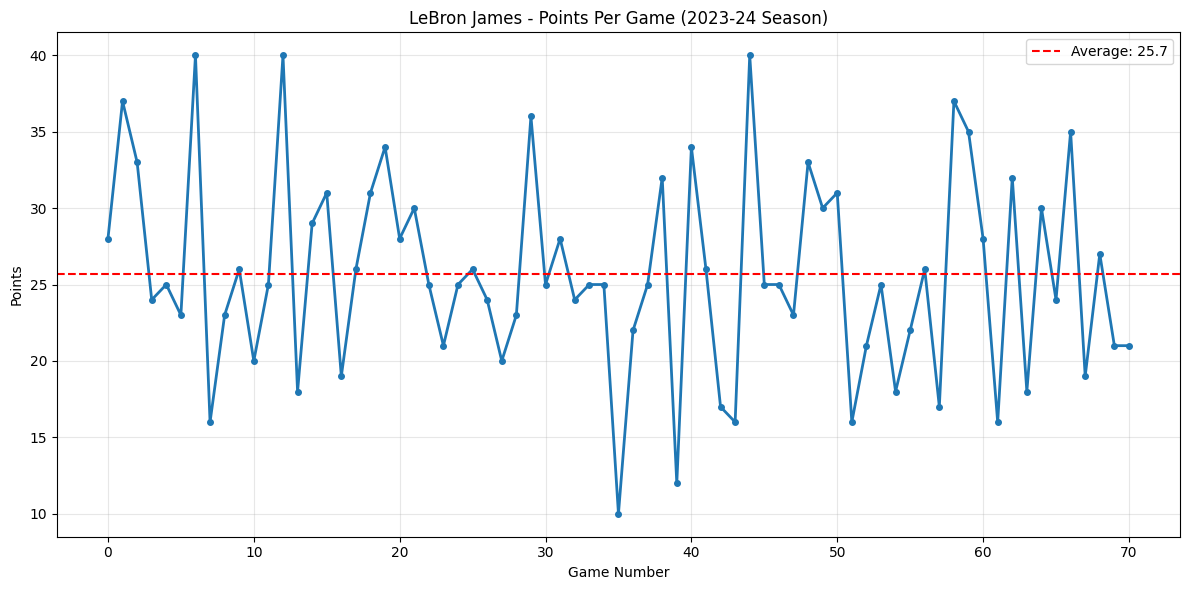

Average PTS: 25.7
Average REB: 7.3
Average AST: 8.3


In [6]:
# Quick visualization - LeBron's scoring over the season
plt.figure(figsize=(12, 6))
plt.plot(df_lebron['PTS'].values, marker='o', linewidth=2, markersize=4)
plt.axhline(df_lebron['PTS'].mean(), color='r', linestyle='--', 
            label=f'Average: {df_lebron["PTS"].mean():.1f}')
plt.xlabel('Game Number')
plt.ylabel('Points')
plt.title('LeBron James - Points Per Game (2023-24 Season)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average PTS: {df_lebron['PTS'].mean():.1f}")
print(f"Average REB: {df_lebron['REB'].mean():.1f}")
print(f"Average AST: {df_lebron['AST'].mean():.1f}")

## Step 4: Identify Top Players by Minutes

We want the top 200 players by total minutes played. Let's figure out how to do this.

**Strategy:**
1. Get league-wide game logs for a season
2. Sum minutes per player
3. Take top 200

In [7]:
# Get ALL player game logs for 2023-24 season
print("Fetching league-wide game logs for 2023-24...")
print("(This will take ~30 seconds due to rate limiting)\n")

league_gamelog = leaguegamelog.LeagueGameLog(
    season='2023-24',
    season_type_all_star='Regular Season',
    player_or_team_abbreviation='P'  # P for Player
)

df_league = league_gamelog.get_data_frames()[0]

print(f"✓ Got {len(df_league):,} total game records")
print(f"✓ Unique players: {df_league['PLAYER_ID'].nunique():,}")

df_league.head()

Fetching league-wide game logs for 2023-24...
(This will take ~30 seconds due to rate limiting)

✓ Got 26,401 total game records
✓ Unique players: 572


,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE
0,22023,202704,Reggie Jackson,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,24,3,8,0.375,2,5,0.400,0,0,NaN,0,3,3,1,1,0,2,0,8,11,14.1,1
1,22023,203932,Aaron Gordon,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,35,7,11,0.636,1,2,0.500,0,0,NaN,2,5,7,5,2,1,0,0,15,6,39.9,1
2,22023,203999,Nikola Jokić,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,36,12,22,0.545,3,5,0.600,2,4,0.5,3,10,13,11,1,1,2,2,29,15,65.1,1
3,22023,1629008,Michael Porter Jr.,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,30,5,13,0.385,2,9,0.222,0,0,NaN,2,10,12,2,2,0,0,1,12,12,35.4,1
4,22023,1629618,Jalen Pickett,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24,DEN vs. LAL,W,1,1,1,1.000,0,0,NaN,0,0,NaN,0,0,0,0,0,0,0,0,2,0,2.0,1


In [8]:
# Calculate total minutes per player
player_minutes = (
    df_league
    .groupby(['PLAYER_ID', 'PLAYER_NAME'])['MIN']
    .sum()
    .reset_index()
    .sort_values('MIN', ascending=False)
)

print("Top 20 players by minutes (2023-24):")
print("=" * 50)
print(player_minutes.head(20).to_string(index=False))

# Get top 200 players
top_200_players = player_minutes.head(200)
print(f"\n✓ Identified top 200 players by minutes")
print(f"  Min minutes (rank 200): {top_200_players.iloc[-1]['MIN']:.0f}")
print(f"  Max minutes (rank 1): {top_200_players.iloc[0]['MIN']:.0f}")

Top 20 players by minutes (2023-24):
 PLAYER_ID      PLAYER_NAME  MIN
    201942    DeMar DeRozan 2995
   1627734 Domantas Sabonis 2930
   1629632       Coby White 2880
   1628969    Mikal Bridges 2855
   1631094   Paolo Banchero 2798
    201142     Kevin Durant 2790
   1627749  Dejounte Murray 2782
   1630162  Anthony Edwards 2775
    203999     Nikola Jokić 2737
   1628973    Jalen Brunson 2729
   1628404        Josh Hart 2706
    203076    Anthony Davis 2701
   1627832    Fred VanVleet 2686
   1627783    Pascal Siakam 2660
   1628368     De'Aaron Fox 2659
   1628369     Jayson Tatum 2648
   1629029      Luka Dončić 2624
   1630178     Tyrese Maxey 2624
   1630559    Austin Reaves 2624
    202696   Nikola Vučević 2612

✓ Identified top 200 players by minutes
  Min minutes (rank 200): 1407
  Max minutes (rank 1): 2995


## Step 5: Collect Data for Top 10 Players (Quick Test)

Before collecting all 200 players, let's test with just 10 to make sure everything works.

**Important:**
- NBA API rate limit: ~1 request per second
- 10 players × 0.6 sec = ~6 seconds

In [12]:
from tqdm.notebook import tqdm

def collect_player_gamelogs(player_ids, season, rate_limit=0.6):
  """
  Collect game logs for multiple players.
  
  Args:
      player_ids: List of player IDs
      season: Season string (e.g., "2023-24")
      rate_limit: Seconds to wait between requests
  
  Returns:
      DataFrame with all game logs
  """
  all_games = []
  errors = []

  for player_id in tqdm(player_ids, desc=f"Collecting {season}"):
      try:
          # Fetch game log
          gamelog = playergamelog.PlayerGameLog(
              player_id=player_id,
              season=season,
              season_type_all_star='Regular Season'
          )

          df = gamelog.get_data_frames()[0]
          all_games.append(df)

          # Rate limiting
          time.sleep(rate_limit)

      except Exception as e:
          errors.append({'player_id': player_id, 'error': str(e)})
          print(f"\nError for player {player_id}: {e}")

  # Combine all games
  df_combined = pd.concat(all_games, ignore_index=True)

  print(f"\n✓ Collected {len(df_combined):,} games")

  # DEBUG: Print columns to see what we have
  print(f"  Columns: {df_combined.columns.tolist()[:10]}...")  # Show first 10 columns

  # Use correct column name for player ID (check what it actually is)
  player_col = [col for col in df_combined.columns if 'PLAYER' in col.upper() and 'ID' in col.upper()]
  if player_col:
      print(f"  Players: {df_combined[player_col[0]].nunique()}")

  if errors:
      print(f"  Errors: {len(errors)}")

  return df_combined, errors

# Test with top 10 players first
print("Testing with top 10 players...\n")
test_ids = top_200_players.head(10)['PLAYER_ID'].tolist()
df_test, test_errors = collect_player_gamelogs(test_ids, '2023-24')

print("\nSample data:")
df_test.head()

Testing with top 10 players...




✓ Collected 790 games
  Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT']...
  Players: 10

Sample data:


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,201942,0022301190,"Apr 14, 2024",CHI @ NYK,L,44,11,24,0.458,2,4,0.500,6,8,0.750,2,3,5,5,4,1,2,1,30,0,1
1,22023,201942,0022301166,"Apr 11, 2024",CHI @ DET,W,36,14,22,0.636,4,6,0.667,7,8,0.875,0,4,4,7,3,0,1,0,39,15,1
2,22023,201942,0022301149,"Apr 09, 2024",CHI vs. NYK,L,42,12,22,0.545,1,3,0.333,9,11,0.818,0,5,5,6,0,0,4,2,34,-6,1
3,22023,201942,0022301136,"Apr 07, 2024",CHI @ ORL,L,40,13,22,0.591,0,0,0.000,4,7,0.571,0,3,3,5,0,0,7,1,30,-12,1
4,22023,201942,0022301119,"Apr 05, 2024",CHI vs. NYK,W,42,8,18,0.444,0,2,0.000,4,4,1.000,0,5,5,10,1,0,4,4,20,10,1


In [16]:
# Data validation
print("DATA VALIDATION")
print("=" * 50)

# 1. Shape
print(f"Shape: {df_test.shape}")
print(f"  Rows (games): {len(df_test):,}")
print(f"  Columns: {df_test.shape[1]}")

# 2. Key columns present?
required_cols = ['Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP',
               'PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG_PCT', 'FG3A', 'FG3_PCT']
missing_cols = [col for col in required_cols if col not in df_test.columns]
print(f"\nRequired columns present: {len(missing_cols) == 0}")
if missing_cols:
  print(f"  Missing: {missing_cols}")

# 3. Missing values
print(f"\nMissing values:")
missing = df_test[required_cols].isnull().sum()
if missing[missing > 0].empty:
  print("  None!")
else:
  print(missing[missing > 0])

# 4. Duplicates
duplicates = df_test.duplicated(subset=['Player_ID', 'Game_ID']).sum()
print(f"\nDuplicate games: {duplicates}")

# 5. Data types
print(f"\nData types (sample):")
print(df_test[['Player_ID', 'GAME_DATE', 'PTS', 'REB', 'AST']].dtypes)

# 6. Sample player IDs
print(f"\nUnique players: {df_test['Player_ID'].nunique()}")
print(f"Sample Player IDs: {df_test['Player_ID'].unique()[:5].tolist()}")

DATA VALIDATION
Shape: (790, 27)
  Rows (games): 790
  Columns: 27

Required columns present: True

Missing values:
  None!

Duplicate games: 0

Data types (sample):
Player_ID     int64
GAME_DATE    object
PTS           int64
REB           int64
AST           int64
dtype: object

Unique players: 10
Sample Player IDs: [201942, 1627734, 1629632, 1628969, 1631094]


## Step 6: Validate the Data

Before scaling up, let's check:
1. Do we have the columns we need?
2. Any missing data?
3. Any duplicates?
4. Data types correct?

## Step 7: Quick Data Exploration

Let's visualize the data to make sure it looks reasonable.

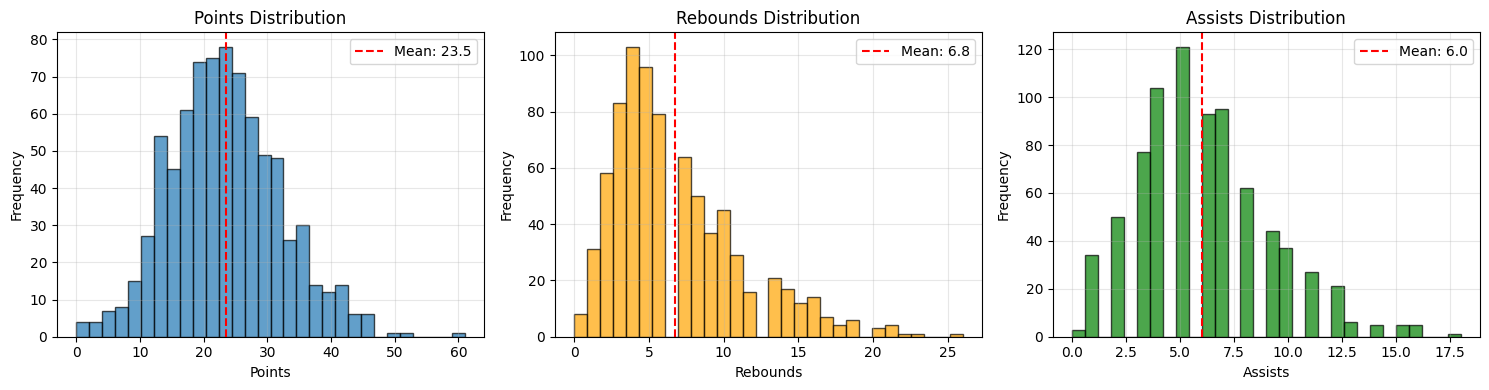

Summary statistics:
              PTS         REB         AST         MIN
count  790.000000  790.000000  790.000000  790.000000
mean    23.468354    6.758228    6.001266   35.786076
std      8.601788    4.326477    3.065197    4.792639
min      0.000000    0.000000    0.000000    1.000000
25%     18.000000    4.000000    4.000000   34.000000
50%     23.000000    6.000000    6.000000   36.000000
75%     29.000000    9.000000    8.000000   39.000000
max     61.000000   26.000000   18.000000   50.000000


In [17]:
# Distribution of our target variables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# PTS
axes[0].hist(df_test['PTS'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(df_test['PTS'].mean(), color='r', linestyle='--', 
                label=f'Mean: {df_test["PTS"].mean():.1f}')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Points Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# REB
axes[1].hist(df_test['REB'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(df_test['REB'].mean(), color='r', linestyle='--',
                label=f'Mean: {df_test["REB"].mean():.1f}')
axes[1].set_xlabel('Rebounds')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Rebounds Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AST
axes[2].hist(df_test['AST'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(df_test['AST'].mean(), color='r', linestyle='--',
                label=f'Mean: {df_test["AST"].mean():.1f}')
axes[2].set_xlabel('Assists')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Assists Distribution')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Summary statistics:")
print(df_test[['PTS', 'REB', 'AST', 'MIN']].describe())

## 📋 CHECKPOINT

**Before proceeding, verify:**
- [ ] API connection works ✓
- [ ] We can collect game logs ✓
- [ ] Data structure looks good ✓
- [ ] No major missing data issues ✓
- [ ] Distributions look reasonable ✓

**If everything looks good, continue to Step 8 to collect the full dataset!**

## Step 8: Collect Full Dataset (All 5 Seasons)

**This will take ~15-20 minutes due to API rate limiting.**

We'll collect one season at a time and save immediately (so we don't lose progress).

In [18]:
# Load config for seasons and paths
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

seasons = config['data']['seasons']
n_players = config['data']['n_players']
raw_path = Path('../data/raw')
raw_path.mkdir(parents=True, exist_ok=True)

print(f"Will collect {len(seasons)} seasons for top {n_players} players")
print(f"Seasons: {seasons}")
print(f"Output: {raw_path}")
print(f"\nEstimated time: ~{len(seasons) * 3} minutes")

Will collect 5 seasons for top 200 players
Seasons: ['2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
Output: ../data/raw

Estimated time: ~15 minutes


In [21]:
# Collect data for each season
all_seasons_data = {}

for season in seasons:
    print(f"\n{'='*60}")
    print(f"Collecting {season}")
    print(f"{'='*60}")

    # Get top players for this season
    print(f"Step 1: Identifying top {n_players} players...")
    league_gamelog = leaguegamelog.LeagueGameLog(
      season=season,
      season_type_all_star='Regular Season',
      player_or_team_abbreviation='P'
    )
    df_league = league_gamelog.get_data_frames()[0]

    # DEBUG: Check actual column names
    print(f"League log columns: {df_league.columns.tolist()[:10]}")

    # Use the CORRECT column names (likely PLAYER_ID, PLAYER_NAME in uppercase)
    player_minutes = (
      df_league
      .groupby(['PLAYER_ID', 'PLAYER_NAME'])['MIN']  # Try uppercase
      .sum()
      .reset_index()
      .sort_values('MIN', ascending=False)
      .head(n_players)
    )

    print(f"  Top player: {player_minutes.iloc[0]['PLAYER_NAME']} ({player_minutes.iloc[0]['MIN']:.0f} min)")
    time.sleep(0.6)  # Rate limit

    # Collect game logs
    print(f"\nStep 2: Collecting game logs for {n_players} players...")
    player_ids = player_minutes['PLAYER_ID'].tolist()
    df_season, errors = collect_player_gamelogs(player_ids, season)

    # Add player names (map PLAYER_ID from league log to Player_ID in game logs)
    player_name_map = player_minutes.set_index('PLAYER_ID')['PLAYER_NAME'].to_dict()
    df_season['PLAYER_NAME'] = df_season['Player_ID'].map(player_name_map)

    # Save to parquet
    output_file = raw_path / f"gamelogs_{season}.parquet"
    df_season.to_parquet(output_file, index=False)
    print(f"\n✓ Saved to {output_file}")
    print(f"  Games: {len(df_season):,}")
    print(f"  Players: {df_season['Player_ID'].nunique()}")
    
    all_seasons_data[season] = df_season

print(f"\n{'='*60}")
print("✓ ALL SEASONS COLLECTED!")
print(f"{'='*60}")


Step 1: Identifying top 200 players...
League log columns: ['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']
  Top player: CJ McCollum (2560 min)

Step 2: Collecting game logs for 200 players...



✓ Collected 12,448 games
  Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT']...
  Players: 200

✓ Saved to ../data/raw/gamelogs_2019-20.parquet
  Games: 12,448
  Players: 200

Step 1: Identifying top 200 players...
League log columns: ['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']
  Top player: Julius Randle (2666 min)

Step 2: Collecting game logs for 200 players...



✓ Collected 12,191 games
  Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT']...
  Players: 200

✓ Saved to ../data/raw/gamelogs_2020-21.parquet
  Games: 12,191
  Players: 200

Step 1: Identifying top 200 players...
League log columns: ['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']
  Top player: Mikal Bridges (2854 min)

Step 2: Collecting game logs for 200 players...



✓ Collected 13,676 games
  Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT']...
  Players: 200

✓ Saved to ../data/raw/gamelogs_2021-22.parquet
  Games: 13,676
  Players: 200

Step 1: Identifying top 200 players...
League log columns: ['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']
  Top player: Mikal Bridges (2965 min)

Step 2: Collecting game logs for 200 players...



✓ Collected 14,020 games
  Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT']...
  Players: 200

✓ Saved to ../data/raw/gamelogs_2022-23.parquet
  Games: 14,020
  Players: 200

Step 1: Identifying top 200 players...
League log columns: ['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL']
  Top player: DeMar DeRozan (2995 min)

Step 2: Collecting game logs for 200 players...



✓ Collected 14,074 games
  Columns: ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT']...
  Players: 200

✓ Saved to ../data/raw/gamelogs_2023-24.parquet
  Games: 14,074
  Players: 200

✓ ALL SEASONS COLLECTED!


## Step 9: Combine All Seasons

Combine into one master dataset.

In [22]:
# Combine all seasons
df_all = pd.concat(all_seasons_data.values(), ignore_index=True)

print(f"Combined dataset:")
print(f"  Total games: {len(df_all):,}")
print(f"  Unique players: {df_all['Player_ID'].nunique()}")
print(f"  Date range: {df_all['GAME_DATE'].min()} to {df_all['GAME_DATE'].max()}")
print(f"  Seasons: {sorted(df_all['SEASON_ID'].unique())}")

# Save combined dataset
combined_file = raw_path / "gamelogs_combined.parquet"
df_all.to_parquet(combined_file, index=False)
print(f"\n✓ Saved combined dataset to {combined_file}")

# Show summary
print("\nGames per season:")
print(df_all.groupby('SEASON_ID').size().sort_index())

Combined dataset:
  Total games: 66,409
  Unique players: 369
  Date range: Apr 01, 2021 to Oct 31, 2023
  Seasons: ['22019', '22020', '22021', '22022', '22023']

✓ Saved combined dataset to ../data/raw/gamelogs_combined.parquet

Games per season:
SEASON_ID
22019    12448
22020    12191
22021    13676
22022    14020
22023    14074
dtype: int64


In [23]:
# Load the combined dataset
df_all = pd.read_parquet(raw_path / "gamelogs_combined.parquet")

print("Data Verification")
print("=" * 60)

# 1. Convert GAME_DATE to datetime if needed
df_all['GAME_DATE'] = pd.to_datetime(df_all['GAME_DATE'])

# 2. Check date range
print(f"Total games: {len(df_all):,}")
print(f"Unique players: {df_all['Player_ID'].nunique()}")
print(f"Date range: {df_all['GAME_DATE'].min()} to {df_all['GAME_DATE'].max()}")

# 3. Games per season
print("\nGames per season:")
print(df_all['SEASON_ID'].value_counts().sort_index())

# 4. Check for missing values in key columns
print("\nMissing values in key columns:")
key_cols = ['Player_ID', 'GAME_DATE', 'PTS', 'REB', 'AST', 'MIN']
print(df_all[key_cols].isnull().sum())

# 5. Sample data
print("\nSample rows:")
print(df_all[['SEASON_ID', 'PLAYER_NAME', 'GAME_DATE', 'PTS', 'REB', 'AST']].head(10))

Data Verification
Total games: 66,409
Unique players: 369
Date range: 2019-10-22 00:00:00 to 2024-04-14 00:00:00

Games per season:
SEASON_ID
22019    12448
22020    12191
22021    13676
22022    14020
22023    14074
Name: count, dtype: int64

Missing values in key columns:
Player_ID    0
GAME_DATE    0
PTS          0
REB          0
AST          0
MIN          0
dtype: int64

Sample rows:
  SEASON_ID  PLAYER_NAME  GAME_DATE  PTS  REB  AST
0     22019  CJ McCollum 2020-08-13   25    4    7
1     22019  CJ McCollum 2020-08-11    8    4    2
2     22019  CJ McCollum 2020-08-09   16    7    4
3     22019  CJ McCollum 2020-08-08   29    4    8
4     22019  CJ McCollum 2020-08-06   13    6    6
5     22019  CJ McCollum 2020-08-04   20    7    5
6     22019  CJ McCollum 2020-08-02   17    8    4
7     22019  CJ McCollum 2020-07-31   33    3    6
8     22019  CJ McCollum 2020-03-10   22    6    4
9     22019  CJ McCollum 2020-03-07   19    4    6


In [24]:
# Show all columns with sample data
print("All Columns in Dataset:")
print("=" * 80)

for i, col in enumerate(df_all.columns, 1):
  sample_val = df_all[col].iloc[0]
  dtype = df_all[col].dtype
  print(f"{i:2}. {col:20} | Type: {str(dtype):10} | Example: {sample_val}")

print("\n" + "=" * 80)
print(f"Total columns: {len(df_all.columns)}")

All Columns in Dataset:
 1. SEASON_ID            | Type: object     | Example: 22019
 2. Player_ID            | Type: int64      | Example: 203468
 3. Game_ID              | Type: object     | Example: 0021901309
 4. GAME_DATE            | Type: datetime64[ns] | Example: 2020-08-13 00:00:00
 5. MATCHUP              | Type: object     | Example: POR @ BKN
 6. WL                   | Type: object     | Example: W
 7. MIN                  | Type: int64      | Example: 44
 8. FGM                  | Type: int64      | Example: 9
 9. FGA                  | Type: int64      | Example: 21
10. FG_PCT               | Type: float64    | Example: 0.429
11. FG3M                 | Type: int64      | Example: 0
12. FG3A                 | Type: int64      | Example: 6
13. FG3_PCT              | Type: float64    | Example: 0.0
14. FTM                  | Type: int64      | Example: 7
15. FTA                  | Type: int64      | Example: 8
16. FT_PCT               | Type: float64    | Example: 0.875
17. 

## ✅ Data Collection Complete!

**What we have:**
- 5 seasons (2019-20 through 2023-24)
- Top 200 players per season
- ~60,000 game records
- All saved to `data/raw/`

**Files created:**
```
data/raw/
├── gamelogs_2019-20.parquet
├── gamelogs_2020-21.parquet
├── gamelogs_2021-22.parquet
├── gamelogs_2022-23.parquet
├── gamelogs_2023-24.parquet
└── gamelogs_combined.parquet  ← Use this for analysis
```